In [3]:
import math
import copy
import numpy as np
import scipy.sparse as ssp
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
import cvxpy as cp
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [4]:
# initial value

nRotors = 8
Deg2Rad = np.pi /180
Rad2Deg = 1/Deg2Rad

dt = 0.01            # control frequency
tf = 4.5             # final time
g = 9.8              # m/s^2

l = 1.0              # m
m = 23.56            # kg
Ix = 1.676           # kg m^2
Iy = 1.676           # kg m^2
Iz = 2.9743          # kg m^2

# rotor characteristics
kf = 1.1             # N / V^2
kt = 0.52            # N m / V^2 
rotor_limit = 10                  # rotor limit
rotor_sr_limit = rotor_limit/0.1  # rotor slew rate limit
omega_rotor, zeta_rotor = 40, 0.8

t_fail = 3         # 고장 시간
t_detect = 0.2     # 고장 검출에 걸리는 시간  
r_fail = 5         # 고장 로터 번호
c = l  
loc = np.zeros((nRotors,3))
loc[0] = np.array([ 0.25*c,  2.5*c, 0]) 
loc[1] = np.array([ 0.25*c,  1.5*c, 0])
loc[2] = np.array([ 0.25*c, -1.5*c, 0])
loc[3] = np.array([ 0.25*c, -2.5*c, 0])
loc[4] = np.array([-0.75*c, -2.5*c, 0])
loc[5] = np.array([-0.75*c, -1.5*c, 0])
loc[6] = np.array([-0.75*c,  1.5*c, 0])
loc[7] = np.array([-0.75*c,  2.5*c, 0])
thrust = np.array([0, 0, -kf])
moments = np.cross(loc, thrust)
A = np.zeros((4,nRotors))        # rotor speed (sq) to control (thr/torque)
A[0,:] = np.ones(nRotors)*kf     # thrust
A[[1,2],:] = moments[:,[0,1]].T  # roll moment , pitch moment
A[3,0::2] = -kt                  # yaw moment (CW rotors) 
A[3,1::2] =  kt                  # yaw moment (CCW rotors)
pinvA = np.linalg.pinv(A)

In [5]:
def compute_guidance(state, t, t_index):
    start_time = time.time()
    if not hasattr(compute_guidance, "counter"):
         compute_guidance.counter = 0
         compute_guidance.cmd0 = 0
         compute_guidance.cmd1 = 0
         compute_guidance.cmd2 = 0
         compute_guidance.cmd3 = 0
            
            
    u,v,w,p,q,r,x,y,z,phi,the,psi = state[:12]  # state variables(u,v,w : 기체중심 좌표 / p,q,r : 각속도 / x,y,z : NED 기준 좌표
                                                #                phi,the,psi : 자세각 )
    
    s_phi, c_phi = np.sin(phi), np.cos(phi)
    s_the, c_the = np.sin(the), np.cos(the)
    s_psi, c_psi = np.sin(psi), np.cos(psi)
    
    Cbn = np.array([ \
        [c_psi*c_the, c_psi*s_the*s_phi-s_psi*c_phi, c_psi*s_the*c_phi+s_psi*s_phi], \
        [s_psi*c_the, s_psi*s_the*s_phi+c_psi*c_phi, s_psi*s_the*c_phi-c_psi*s_phi], \
        [     -s_the,                   c_the*s_phi,                   c_the*c_phi] \
    ])

    x_dot,y_dot,z_dot = np.dot(Cbn,[u,v,w])
    h_dot = -z_dot
    h = -z
    
    omg_alt, zet_alt = 2, 0.8
    omg_pos, zet_pos = 2, 0.8
    
    # NED 좌표 기준 위치 명령 h, x, y와 자세각 명령 psi
    if t < t_fail+t_detect:
        
        # 고장 전 자세 명령 산출 loop
        
        h_cmd = 1
        x_cmd = 1
        y_cmd = 2
        psi_cmd = 10*Deg2Rad
    
        # altitude loop
        up_cmd = -2*zet_alt*omg_alt*h_dot + omg_alt**2*(h_cmd-h) + g
        thrust = m*up_cmd/(c_phi*c_the)

        # horizontal position loop
        ax_cmd = -2*zet_pos*omg_pos*x_dot + omg_pos**2*(x_cmd-x)
        ay_cmd = -2*zet_pos*omg_pos*y_dot + omg_pos**2*(y_cmd-y)
        au_cmd, av_cmd, aw_cmd = np.dot(Cbn.T,[ax_cmd,ay_cmd,0])
        the_cmd = np.arctan2(-au_cmd,g)
        phi_cmd = np.arctan2( av_cmd,g)

    else :
        
        # 고장 검출 후 자세 명령 산출 loop(compute_guidance_cvx함수로 계산)
        
        if (1):
            thrust, phi_cmd, the_cmd, psi_cmd = compute_guidance_cvx([x,y,z],[x_dot,y_dot,z_dot],psi,tf-t)
            compute_guidance.cmd0 = thrust
            compute_guidance.cmd1 = phi_cmd
            compute_guidance.cmd2 = the_cmd
            compute_guidance.cmd3 = psi_cmd
            end_time = time.time()
            elapsed_time = end_time - start_time
            print("convex problem: ",elapsed_time)
        else:
            thrust = compute_guidance.cmd0
            phi_cmd = compute_guidance.cmd1
            the_cmd = compute_guidance.cmd2
            psi_cmd = compute_guidance.cmd3
            end_time = time.time()
            elapsed_time = end_time - start_time
            print("skip: ",elapsed_time)
        compute_guidance.counter += 1

    return np.array([thrust, phi_cmd, the_cmd, psi_cmd])

In [6]:
# quadrotor 6DOF dynamics
def state_derivative(state, t, rotor_cmd, flag_fail):  # computes state derivatives  
    u,v,w,p,q,r,x,y,z,phi,the,psi = state[:12]         # state variables
    rotor = state[12:12+nRotors]         
    rotor_dot = state[12+nRotors:]  
    rotor = np.clip(rotor, 0, rotor_limit)                           # rotor limit
    rotor_dot = np.clip(rotor_dot, -rotor_sr_limit, rotor_sr_limit)  # rotor speed slew rate limit
    if flag_fail and t > t_fail:
        state[12+r_fail] = 0
        rotor[r_fail] = 0
        rotor_dot[r_fail] = 0
    T,L,M,N = A@(rotor**2)                           # control variable
 
    s_phi, c_phi = np.sin(phi), np.cos(phi)
    s_the, c_the = np.sin(the), np.cos(the)
    s_psi, c_psi = np.sin(psi), np.cos(psi)
    
    u_dot   = -g*s_the       - (q*w - r*v)
    v_dot   =  g*c_the*s_phi - (r*u - p*w)
    w_dot   =  g*c_the*c_phi - (p*v - q*u) - T/m
    
    if z>0:
        u_dot -= -g*s_the
        v_dot -=  g*c_the*s_phi
        w_dot -=  g*c_the*c_phi
    
    p_dot   = -(Iz-Iy)/Ix*q*r + L/Ix 
    q_dot   = -(Ix-Iz)/Iy*r*p + M/Iy
    r_dot   = -(Iy-Ix)/Iz*p*q + N/Iz
    
    Cbn = np.array([ \
        [c_psi*c_the, c_psi*s_the*s_phi-s_psi*c_phi, c_psi*s_the*c_phi+s_psi*s_phi], \
        [s_psi*c_the, s_psi*s_the*s_phi+c_psi*c_phi, s_psi*s_the*c_phi-c_psi*s_phi], \
        [     -s_the,                   c_the*s_phi,                   c_the*c_phi] \
    ])
    
    x_dot,y_dot,z_dot = np.dot(Cbn,np.array([u,v,w]))
    
    phi_dot = p + s_phi*s_the/c_the*q + c_phi*s_the/c_the*r
    the_dot =                 c_phi*q -             s_phi*r
    psi_dot =           s_phi/c_the*q +       c_phi/c_the*r
    
    rotor_ddot = -2*zeta_rotor*omega_rotor*rotor_dot \
                  + omega_rotor**2*(rotor_cmd-rotor)

    return np.array([u_dot,v_dot,w_dot,p_dot,q_dot,r_dot,x_dot,y_dot,z_dot, \
                     phi_dot,the_dot,psi_dot,*rotor_dot,*rotor_ddot])



In [7]:
# control computation
def compute_control(guidance_cmd, state, t):
    
    u,v,w,p,q,r,x,y,z,phi,the,psi = state[:12]  # state variables
    thrust, phi_cmd, the_cmd, psi_cmd = guidance_cmd
    
    #loop gain
    
    omg_phi, zet_phi = 8, 0.7
    omg_the, zet_the = 8, 0.7
    omg_psi, zet_psi = 4, 0.9
    
    #자세각 명령으로부터 토크 명령 산출
    
    torque_phi = -2*zet_phi*omg_phi*p + omg_phi**2*(phi_cmd-phi)
    torque_the = -2*zet_the*omg_the*q + omg_the**2*(the_cmd-the)
    torque_psi = -2*zet_psi*omg_psi*r + omg_psi**2*(psi_cmd-psi)
    torque_phi *= Ix
    torque_the *= Iy
    torque_psi *= Iz
        
    return np.array([thrust,torque_phi,torque_the,torque_psi])


# 로터 회전수 산출
def mix_actuators(control):
    rotor = pinvA@control
    return np.sqrt(np.clip(rotor,0,100))

# 로터 회전수 산출(cvx)
def mix_actuators_cvx(control, r_p, k, flag_fail):
    W = np.eye(4)
    
    r = cp.Variable(nRotors,nonneg=True)
    obj_req = cp.sum_squares(W@(A@r-control))
    obj_smooth = 1e-4*cp.sum_squares(r-r_p)
    #obj_card = 0.1*cp.norm(r,1)
    #obj_max = 0.01*cp.max(r)
    #obj_energy = 1e-6*cp.sum_squares(r)
    #obj = cp.Minimize( obj_req + obj_smooth + obj_card )
    obj = cp.Minimize( obj_req + obj_smooth)
    constr = [ r <= 100 ]
    if flag_fail and k*dt > t_fail + t_detect:
        constr += [r[r_fail]==0]
    cp.Problem(obj, constr).solve(verbose=False)
    rotor = r.value
    return np.sqrt(np.clip(rotor,0,100))

In [8]:
def flight(state, t, time_arrival):
    start_time = time.time()
    if not hasattr(compute_guidance, "counter"):
         compute_guidance.counter = 0
         compute_guidance.cmd0 = 0
         compute_guidance.cmd1 = 0
         compute_guidance.cmd2 = 0
         compute_guidance.cmd3 = 0
            
            
    u,v,w,p,q,r,x,y,z,phi,the,psi = state[:12]  # state variables(u,v,w : 기체중심 좌표 / p,q,r : 각속도 / x,y,z : NED 기준 좌표
                                                #                phi,the,psi : 자세각 )
    
    s_phi, c_phi = np.sin(phi), np.cos(phi)
    s_the, c_the = np.sin(the), np.cos(the)
    s_psi, c_psi = np.sin(psi), np.cos(psi)
    
    Cbn = np.array([ \
        [c_psi*c_the, c_psi*s_the*s_phi-s_psi*c_phi, c_psi*s_the*c_phi+s_psi*s_phi], \
        [s_psi*c_the, s_psi*s_the*s_phi+c_psi*c_phi, s_psi*s_the*c_phi-c_psi*s_phi], \
        [     -s_the,                   c_the*s_phi,                   c_the*c_phi] \
    ])

    x_dot,y_dot,z_dot = np.dot(Cbn,[u,v,w])
    h_dot = -z_dot
    h = -z
    
    omg_alt, zet_alt = 2, 0.8
    omg_pos, zet_pos = 2, 0.8
    
    # NED 좌표 기준 위치 명령 h, x, y와 자세각 명령 psi
    if t < t_fail+t_detect:
        
        # 고장 전 자세 명령 산출 loop
        
        h_cmd = 1
        x_cmd = 1
        y_cmd = 2
        psi_cmd = 10*Deg2Rad
    
        # altitude loop
        up_cmd = -2*zet_alt*omg_alt*h_dot + omg_alt**2*(h_cmd-h) + g
        thrust = m*up_cmd/(c_phi*c_the)

        # horizontal position loop
        ax_cmd = -2*zet_pos*omg_pos*x_dot + omg_pos**2*(x_cmd-x)
        ay_cmd = -2*zet_pos*omg_pos*y_dot + omg_pos**2*(y_cmd-y)
        au_cmd, av_cmd, aw_cmd = np.dot(Cbn.T,[ax_cmd,ay_cmd,0])
        the_cmd = np.arctan2(-au_cmd,g)
        phi_cmd = np.arctan2( av_cmd,g)

    else :
        
        # 고장 검출 후 자세 명령 산출 loop(compute_guidance_cvx함수로 계산)
        
        if (1):
            thrust, phi_cmd, the_cmd, psi_cmd = ADMM_compute_guidance(np.array([x,y,z]),np.array([x_dot,y_dot,z_dot]),psi,time_arrival-t)
            compute_guidance.cmd0 = thrust
            compute_guidance.cmd1 = phi_cmd
            compute_guidance.cmd2 = the_cmd
            compute_guidance.cmd3 = psi_cmd
            end_time = time.time()
            elapsed_time = end_time - start_time
            print("ADMM elapsed time : ",elapsed_time)
        else:
            thrust = compute_guidance.cmd0
            phi_cmd = compute_guidance.cmd1
            the_cmd = compute_guidance.cmd2
            psi_cmd = compute_guidance.cmd3
            end_time = time.time()
            elapsed_time = end_time - start_time
            print("skip: ",elapsed_time)        
        
        compute_guidance.counter += 1

    return np.array([thrust, phi_cmd, the_cmd, psi_cmd])

In [24]:
def ADMM_compute_guidance(position, velocity, psi, tgo):
    delt = 0.05
    T = tgo
    N = int(T/delt)
    Tc = 720

    rho = 1e8
    
    G = np.zeros((3,3*N))
    H = np.zeros((3,3*N))
    I = np.eye(3*N)
    
    for i in range(N):
        G[:, 3*i:3*(i+1)] = (N-1-i)*delt**2/m*np.eye(3)
        H[:, 3*i:3*(i+1)] =  delt/m*np.eye(3)

    A = ssp.vstack((ssp.csr_matrix(G),ssp.csr_matrix(H),ssp.csr_matrix(I) ))
    B = ssp.vstack((ssp.csr_matrix(np.zeros((6,3*N))),ssp.csr_matrix(I) ))
    
    A_all = ssp.vstack((A,ssp.csr_matrix(2*I/np.sqrt(rho)) ))

    r_0 = position
    v_0 = velocity

    r_des = np.zeros(3)
    r_des[0] = 1
    r_des[1] = 1
    r_des[2] = 0

    v_des = np.zeros(3)

    g_pin = np.zeros(3)
    g_pin[2] = 9.8

    r = r_des - (r_0 + N*delt*v_0 + delt**2*(N-1)*N/2*g_pin)
    v = v_des - (v_0 + N*delt*g_pin)

    y = np.hstack((r,v,np.zeros(3*N)))
    
    A_init = ssp.vstack((ssp.csr_matrix(G),ssp.csr_matrix(H),ssp.csr_matrix(2*I/np.sqrt(rho))))
    z = sla.lsqr(A_init,y)[0]
    
    u = np.zeros(3*N+6) 
    
    iter = 100
    
    for i in range(iter):
        c = np.hstack((y + B*z - u,np.zeros(3*N)))
        x, istop = sla.lsqr(A_all,c)[:2]    #x update
        
        if istop == 0 or i == iter-1:
            break

        for j in range(N):                      #z update
            z[2+3*j] = min(0,x[2+3*j])
            Thr = np.sqrt(x[3*j]**2 + x[3*j+1]**2 + z[3*j+2]**2)
            
            if  Thr > Tc:
                z[3*j] = Tc*x[3*j]/Thr
                z[3*j+1] = Tc*x[3*j+1]/Thr
                z[3*j+2] = Tc*z[3*j+2]/Thr
            else:
                z[3*j] = x[3*j]
                z[3*j+1] = x[3*j+1]
                z[3*j+2] = z[3*j+2]
                
        u = u + A*x - B*z -y                   #u update dual ascent

    if position[2]>=0 or istop == 0:
        thrust, phi_cmd, the_cmd, psi_cmd = 0, 0, 0, 0 
    
    else:
        T_n, T_e, T_d = x[:3]
        T_a =  T_n*np.cos(psi) + T_e*np.sin(psi)
        T_b = -T_n*np.sin(psi) + T_e*np.cos(psi)

        thrust = np.sqrt(T_d**2+T_n**2+T_e**2)
        the_cmd = -np.arctan2(T_a,-T_d)
        phi_cmd = np.arcsin(T_b/thrust)
        psi_cmd = psi
    
    return np.array([thrust,phi_cmd,the_cmd,psi_cmd])    

In [25]:
u0, v0, w0 = 0, 0, 0
p0, q0, r0 = 0, 0, 0
x0, y0, z0 = 0, 0, 0
phi0, the0, psi0 = 0, 0, 0
rotor0 = np.zeros(nRotors)
rotor_dot0 = np.zeros(nRotors)
X0 = np.array([u0,v0,w0,p0,q0,r0,x0,y0,z0,phi0,the0,psi0,*rotor0,*rotor_dot0])
G0 = np.zeros(4)
U0 = np.zeros(4)
R0 = np.zeros(nRotors)

time_arrival = 4.3

t = np.arange(0,time_arrival, dt)
n = len(t)
X = np.zeros((len(X0),n))
dX = np.zeros((len(X0),n))
G = np.zeros((len(G0),n-1))
U = np.zeros((len(U0),n-1))
R = np.zeros((len(R0),n-1))
X[:,0] = X0
G[:,0] = G0
U[:,0] = U0
R[:,0] = R0

dotX_p = X0*0


#simulation loop
for k in range(n-1):
    
    G[:,k] = flight(X[:,k],t[k],time_arrival)
    
    U[:,k] = compute_control(G[:,k],X[:,k],t[k])

    if k==0:
        R_p = np.zeros(nRotors)
    else:
        R_p = R[:,k-1]**2
    if k%100==0:
        print(k, end=' ')

    R[:,k] = mix_actuators_cvx(U[:,k],R_p, k, True)    # rotor_rpm_cmd compute
    dotX = state_derivative(X[:,k],t[k],R[:,k], True)  # fail sim
    dX[:,k+1] = dotX                                   # state derivative
    X[:,k+1] = X[:,k] + 0.5*(3*dotX-dotX_p)*dt         # state update
    dotX_p = dotX

    if t[k]>1 and X[8,k+1]>0:
        X[:,k+2:] = X[:,k+1].reshape(-1,1)
        break

0 100 200 300 ADMM elapsed time :  0.06566309928894043
ADMM elapsed time :  0.06859707832336426
ADMM elapsed time :  0.06592202186584473
ADMM elapsed time :  0.07144379615783691
ADMM elapsed time :  0.06406283378601074
ADMM elapsed time :  0.06329989433288574
ADMM elapsed time :  0.06464099884033203
ADMM elapsed time :  0.06009101867675781
ADMM elapsed time :  0.05839896202087402
ADMM elapsed time :  0.06167006492614746
ADMM elapsed time :  0.06466794013977051
ADMM elapsed time :  0.0647740364074707
ADMM elapsed time :  0.06537294387817383
ADMM elapsed time :  0.0634770393371582
ADMM elapsed time :  0.062248945236206055
ADMM elapsed time :  0.061724185943603516
ADMM elapsed time :  0.05875205993652344
ADMM elapsed time :  0.05781292915344238
ADMM elapsed time :  0.05785107612609863
ADMM elapsed time :  0.06150031089782715
ADMM elapsed time :  0.057353973388671875
ADMM elapsed time :  0.057436227798461914
ADMM elapsed time :  0.058609962463378906
ADMM elapsed time :  0.06040215492248535

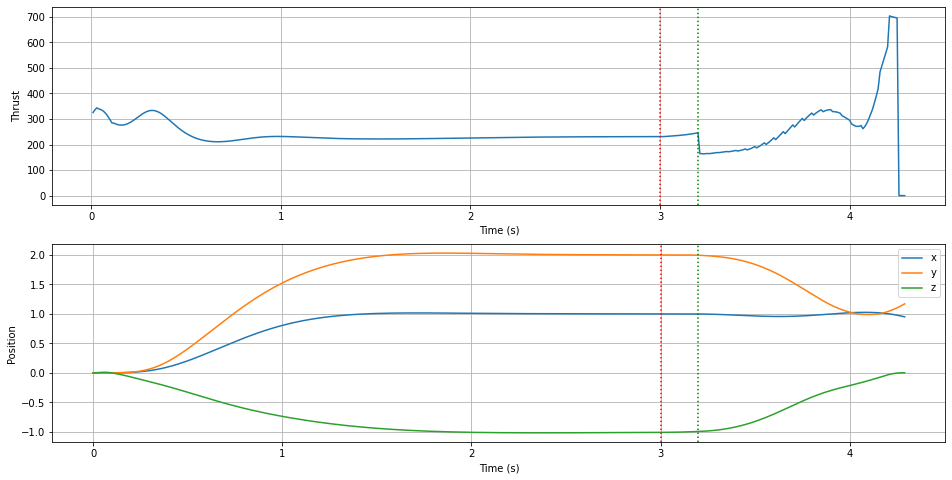

In [27]:
plt.figure(figsize=(16,8))
plt.subplot(211)
plt.plot(t[1:],G[0,:])
plt.axvline(t_fail, linestyle=':',  color='r')
plt.axvline(t_fail + t_detect, linestyle=':',  color='g')
plt.ylabel("Thrust")
plt.xlabel("Time (s)")
plt.grid()

plt.subplot(212)
plt.plot(t[:],X[6,:],label='x')
plt.plot(t[:],X[7,:],label='y')
plt.plot(t[:],X[8,:],label='z')
plt.axvline(t_fail, linestyle=':',  color='r')
plt.axvline(t_fail + t_detect, linestyle=':',  color='g')
plt.ylabel("Position")
plt.xlabel("Time (s)")
plt.legend()
plt.grid()